# An attempt at forecasting booking demand using traditional supervised learning techniques

Since time series analysis did not work out as I had hoped, I will try to provide something of value to the company with traditional supervised learning models.

In my exploratory analysis, I noted that although a significant number of bookings are made with no lead time or little lead time, about 80% of the bookings were made with a lead time greater than one week. 

I think that this percentage of bookings with a lead time over a week affords the opportunity to at least forecast final booking amounts with a high degree of accuray for at least one week out. I believe this because I think the data we have is enough to very easily model cancellation rates to a high degree of accuracy. Furthermore I think a one week forecast is enought time to profitably inform business operational and logistic decisions. 

In order to provide this service, I will first need to be able model booking cancellations.

I will do that in this notebook.

Below, I will demonstrate that I can predict if an individual booking will be canceled with 91% accuracy.

### General Purpose Data Preparation
(See Introduction and Exporatory Data Analysis Notebook)

In [1]:
#Importing libraries and data:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import to dataframe
df = pd.read_csv('hotel_bookings.csv')

#There are two hotels in the data set.
#For increased model accuracy and applicability, I will examine only the Resort Hotel.
df = df[df['hotel'] == 'Resort Hotel']

In [3]:
#Drop rows missing country data.
df = df.dropna(subset=['country'])

#Verify
print(df['country'][df['country'].isna()].head(1))

#Reset index for later dimensionality reduction algorithms.
df = df.reset_index()

Series([], Name: country, dtype: object)


In [4]:
#AGENT: fill missing values with placeholder for self-booking

#Decide on placeholder value
print('max:', df.agent.max())
print('min:', df.agent.min())

#The placeholder for self-booking will be the max value plus one: 536

#Fill
df['agent'] = df['agent'].fillna(536.0)

#Verify
print(df['agent'].isna().head(1))

#New derived feature
df['self_booked'] = df['agent'] != 536.0

max: 535.0
min: 1.0
0    False
Name: agent, dtype: bool


In [5]:
#COMPANY: fill missing values with placeholder for no company
print('max:', df.company.max())
print('min:', df.company.min())

#There is no company id "1", we can use that as our placeholder

#Fill
df['company'] = df['company'].fillna(5.0)

#Verify
print(df['company'].isna().head(1))

#New derived feature
df['on_business'] = df['company'] != 5.0

max: 543.0
min: 6.0
0    False
Name: company, dtype: bool


### EDA: Multivariate Analysis for Cancellation Modeling

#### Multivariate Analysis: Data Manipulation

Much of the provided data is categorical and cannot be analyzed for correlation in it's current format. However, by calculating a cancellation rate for each value of each categorical variable, we can make some potentially useful features.

In [6]:
#Categorical to numerical

#Customer

#We need to be careful not to scew too much toward cancellation, many customers likely only booked
#once and canceled.

#For all customer with 2 or more bookings, customer_cancel_score will show the percentage of their bookings that were fulfilled. Customer only one booking. will be given a score of 1.
df['customer_cancel_score'] = np.round(np.where(df['is_repeated_guest'] > 0, df['previous_bookings_not_canceled']/(df['previous_bookings_not_canceled'] + df['previous_cancellations']), 0), 1)

In [7]:
#Other categorical variables

agent_df = pd.DataFrame(df[['is_canceled','agent']].groupby('agent', as_index=False).agg('mean'))
agent_df = agent_df.rename(index=str, columns={"is_canceled": "agent_cancel_score"})
df = pd.merge(df,agent_df,how='left',on=['agent'])

company_df = pd.DataFrame(df[['is_canceled','company']].groupby('company', as_index=False).agg('mean'))
company_df = company_df.rename(index=str, columns={"is_canceled": "company_cancel_score"})
df = pd.merge(df,company_df,how='left',on=['company'])

country_df = pd.DataFrame(df[['is_canceled','country']].groupby('country', as_index=False).agg('mean'))
country_df = country_df.rename(index=str, columns={"is_canceled": "country_cancel_score"})
df = pd.merge(df,country_df,how='left',on=['country'])

In [8]:
#Demonstration:
#Let's see what we've made!
df[['agent','agent_cancel_score','company','company_cancel_score','country','country_cancel_score']].head(15)

,agent,agent_cancel_score,company,company_cancel_score,country,country_cancel_score
0,536.0,0.176709,5.0,0.29151,PRT,0.421894
1,536.0,0.176709,5.0,0.29151,PRT,0.421894
2,536.0,0.176709,5.0,0.29151,GBR,0.130760
3,304.0,0.000000,5.0,0.29151,GBR,0.130760
4,240.0,0.395770,5.0,0.29151,GBR,0.130760
5,240.0,0.395770,5.0,0.29151,GBR,0.130760
6,536.0,0.176709,5.0,0.29151,PRT,0.421894
7,303.0,0.000000,5.0,0.29151,PRT,0.421894
8,240.0,0.395770,5.0,0.29151,PRT,0.421894
9,15.0,0.385892,5.0,0.29151,PRT,0.421894


In [9]:
#More variables
distribution_channel_df = pd.DataFrame(df[['is_canceled','distribution_channel']].groupby('distribution_channel', as_index=False).agg('mean'))
distribution_channel_df = distribution_channel_df.rename(index=str, columns={"is_canceled": "distribution_channel_score"})
df = pd.merge(df,distribution_channel_df,how='left',on=['distribution_channel'])

market_segment_df = pd.DataFrame(df[['is_canceled','market_segment']].groupby('market_segment', as_index=False).agg('mean'))
market_segment_df = market_segment_df.rename(index=str, columns={"is_canceled": "market_segment_score"})
df = pd.merge(df,market_segment_df,how='left',on=['market_segment']) 

meal_df = pd.DataFrame(df[['is_canceled','meal']].groupby('meal', as_index=False).agg('mean'))
meal_df = meal_df.rename(index=str, columns={"is_canceled": "meal_score"})
df = pd.merge(df,meal_df,how='left',on=['meal'])

deposit_type_df = pd.DataFrame(df[['is_canceled','deposit_type']].groupby('deposit_type', as_index=False).agg('mean'))
deposit_type_df = deposit_type_df.rename(index=str, columns={"is_canceled": "deposit_score"})
df = pd.merge(df,deposit_type_df,how='left',on=['deposit_type'])

### Correlation to target: is_cancelled for round one of feature selection

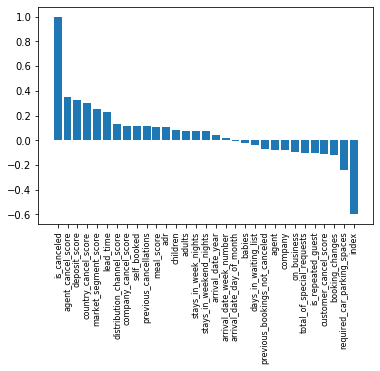

                                       0
is_canceled                     1.000000
agent_cancel_score              0.346178
deposit_score                   0.323021
country_cancel_score            0.302156
market_segment_score            0.252172
lead_time                       0.226453
distribution_channel_score      0.132984
company_cancel_score            0.115995
self_booked                     0.114449
previous_cancellations          0.113666
meal_score                      0.110546
adr                             0.107251
children                        0.080713
adults                          0.077193
stays_in_week_nights            0.076766
stays_in_weekend_nights         0.076345
arrival_date_year               0.043207
arrival_date_week_number        0.020394
arrival_date_day_of_month      -0.009686
babies                         -0.023487
days_in_waiting_list           -0.036766
previous_bookings_not_canceled -0.073661
agent                          -0.077530
company         

In [10]:
is_canceled_corr = pd.DataFrame(df.corrwith(df['is_canceled'])).sort_values(by=0, ascending=0)

plt.bar(is_canceled_corr.index, height = is_canceled_corr[0])
plt.xticks(is_canceled_corr.index, rotation='vertical', fontsize='8')
plt.show()

print(is_canceled_corr)

# Before going on let's analyze this chart:

Some of the most highly correlated features are features that were derived from the data
manipulation done to get usable data from categorical features.

The highest correlated variable are, in order:

        LEAD_TIME_SCORE             0.381711
        AGENT_CANCEL_SCORE          0.346178
        DEPOSIT_SCORE               0.323021
        COUNTRY_CANCEL_SCORE        0.302156
        MARKET_SEGMENT_SCORE        0.252172
    required_car_parking_spaces    -0.243983
    lead_time                       0.226453

The remaining features are much less correlated to is_cancelled than these.

## Addressing Outliers

In [11]:
#Since all of the variables we have elected to include are at or above 14% corrrelation to is_cancelled
#there is no need to analyze the others for outliers.
column_list_one = is_canceled_corr[is_canceled_corr > 0.20].dropna().index
column_list_two = is_canceled_corr[is_canceled_corr < -0.20].dropna().index

column_list = column_list_one.append(column_list_two)

#Non-ratio variables can't have outliers and must be filtered out, we will also filter out the
#variables that we don't intend to use because of weak correlation.
                 
#We'll use the Tukey Interquartile Range method. 

for i in column_list:
    q75, q25 = np.percentile(df[i], [75 ,25])
    iqr = q75 - q25
    threshold = 2
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold for ", i, " is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df[i] > max_val) 
            | (df[i] < min_val))[0]))
    ))

The score threshold for  is_canceled  is: 2
Number of outliers is: 0
The score threshold for  agent_cancel_score  is: 2
Number of outliers is: 206
The score threshold for  deposit_score  is: 2
Number of outliers is: 1861
The score threshold for  country_cancel_score  is: 2
Number of outliers is: 0
The score threshold for  market_segment_score  is: 2
Number of outliers is: 0
The score threshold for  lead_time  is: 2
Number of outliers is: 107
The score threshold for  required_car_parking_spaces  is: 2
Number of outliers is: 5384
The score threshold for  index  is: 2
Number of outliers is: 0


Do we have an outlier problem?

Of the variables that we may use the following have some outliers at a threshold of 2 IQR:

lead_time_score, agent_cancel_score, lead_time, deposit_score, required_car_parking_spaces

Deposit_score doesn't really have outliers. As discussed above, there are only 3 different 
values, each of importance to the model. 

Lead_time is redundant to lead_time_score

This leaves: lead_time_score, agent_cancel_score, lead_time, and required_car_parking_spaces

### Agent Cancel Score

Agent cancel score did not have a lot of outliers 202/39956 = 0.5%. Transforming the data to eliminate outliers did not improve correlation.

I feel it is best to leave the data as it is, as agents have more and more booking with the hotel, the outliers that are of the most importance would eliminate themseles automatically.

count    39596.000000
mean         0.279750
std          0.155393
min          0.000000
25%          0.176709
50%          0.224490
75%          0.395770
max          1.000000
Name: agent_cancel_score, dtype: float64
0.395770    13854
0.176709     7883
0.179748     2854
0.137369     1718
0.081836     1002
0.177174      920
0.334190      778
0.090000      600
0.441905      525
0.054475      514
Name: agent_cancel_score, dtype: int64
corr. w/ no change: 0.34617772922533435


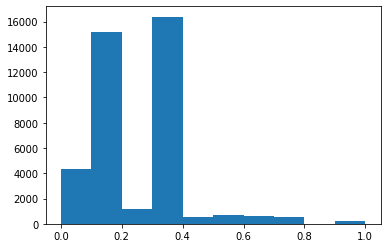

corr. w/ sqrt transformation: 0.3365972542322926


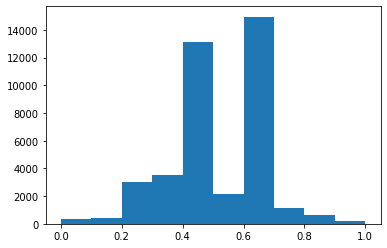

corr. w/ 4thRt transformation: 0.3067989396370724


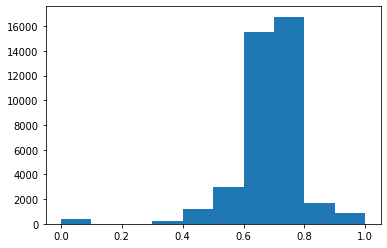

In [12]:
print(df.agent_cancel_score.describe())

print(df.agent_cancel_score.value_counts().head(10))

#The average agent cancels about 37% of the time!

#There is a small but significant number of agents who cancel more than 70% of the time.
#We can't write them out of our analysis.
print('corr. w/ no change:', df.is_canceled.corr(df.agent_cancel_score))
plt.hist(df.agent_cancel_score)
plt.show()

#What does it look like transformed?
print('corr. w/ sqrt transformation:', df.is_canceled.corr(np.sqrt(df.agent_cancel_score)))
plt.hist(np.sqrt(df.agent_cancel_score))
plt.show()

#What about twice?
print('corr. w/ 4thRt transformation:', df.is_canceled.corr(np.sqrt(np.sqrt(df.agent_cancel_score))))
plt.hist(np.sqrt(np.sqrt(df.agent_cancel_score)))
plt.show()

### Lead Time

Lead time has even fewer outliers than agent_cancel_score, with only 107/39956 or 0.26%.

Transforming the data produces a higher correlation though. 

We can run the model later as it is, or with the transformed values.

count    39596.000000
mean        93.438857
std         97.387321
min          0.000000
25%         11.000000
50%         59.000000
75%        155.000000
max        737.000000
Name: lead_time, dtype: float64
0     3122
1     1531
2      904
3      780
4      645
5      580
7      552
6      515
10     388
11     378
8      375
9      361
12     338
17     313
40     308
14     300
13     279
16     275
24     274
15     271
Name: lead_time, dtype: int64
corr. w/ no change: 0.2264526564058416


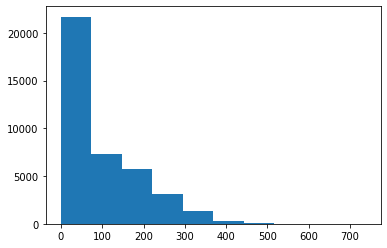

corr. w/ no change: 0.26736483803463224


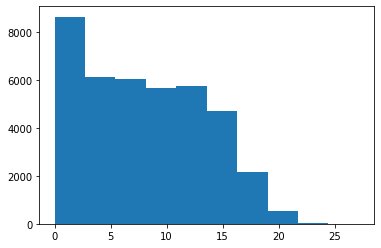

corr. w/ 4thRt transformation: 0.27867542949584123


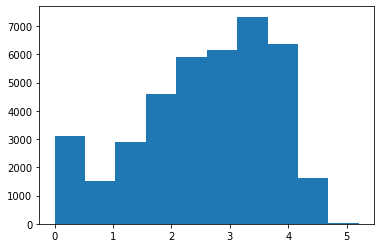

In [13]:
#Lead time is somewhat correlated and has some outliers at a threshold of 2 IQR.
print(df.lead_time.describe())

print(df.lead_time.value_counts().head(20))

print('corr. w/ no change:', df.is_canceled.corr(df.lead_time))
plt.hist(df.lead_time)
plt.show()

#Not exactly normal, but better.
print('corr. w/ no change:', df.is_canceled.corr(np.sqrt(df.lead_time)))
plt.hist(np.sqrt(df.lead_time))
plt.show()

#What about twice?

#This one is a much more normal distribution.
print('corr. w/ 4thRt transformation:', df.is_canceled.corr(np.sqrt(np.sqrt(df.lead_time))))
plt.hist(np.sqrt(np.sqrt(df.lead_time)))
plt.show()

#Our correlation actually improves with the transformation. We will 4thRt. tranform lead time.
df['tf_lead_time'] = np.sqrt(np.sqrt(df.lead_time))

### Car Parking Spaces

In [14]:
#Required_car_parking_spaces has a few outliers,

print(df.required_car_parking_spaces.value_counts())

#Anything over one required space is exceedingly rare. Those values be dropped.
df = df[df['required_car_parking_spaces']<2]

0    34212
1     5356
2       25
8        2
3        1
Name: required_car_parking_spaces, dtype: int64


## Outliers - Part 2

The measures taken above removed all the outliers for lead time, but not much else changed. Outliers don't seem to be a problem with the chosen features though.

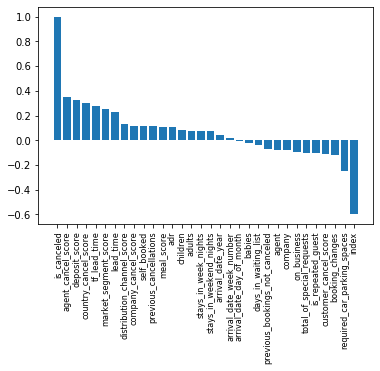

                                       0
is_canceled                     1.000000
agent_cancel_score              0.346268
deposit_score                   0.322963
country_cancel_score            0.302199
tf_lead_time                    0.278811
market_segment_score            0.252391
lead_time                       0.226584
distribution_channel_score      0.133020
company_cancel_score            0.115979
self_booked                     0.114354
previous_cancellations          0.113649
meal_score                      0.110548
adr                             0.107347
children                        0.080892
adults                          0.077293
stays_in_week_nights            0.077033
stays_in_weekend_nights         0.076595
arrival_date_year               0.043372
arrival_date_week_number        0.020182
arrival_date_day_of_month      -0.009602
babies                         -0.023542
days_in_waiting_list           -0.036668
previous_bookings_not_canceled -0.073643
agent           

In [15]:
is_canceled_corr = pd.DataFrame(df.corrwith(df['is_canceled'])).sort_values(by=0, ascending=0)

plt.bar(is_canceled_corr.index, height = is_canceled_corr[0])
plt.xticks(is_canceled_corr.index, rotation='vertical', fontsize='8')
plt.show()

print(is_canceled_corr)

In [16]:
#Since all of the variables we have elected to include are at or above 14% corrrelation to is_cancelled
#there is no need to analyze the others for outliers.
column_list_one = is_canceled_corr[is_canceled_corr > 0.20].dropna().index
column_list_two = is_canceled_corr[is_canceled_corr < -0.20].dropna().index

column_list = column_list_one.append(column_list_two)

#Non-ratio variables can't have outliers and must be filtered out, we will also filter out the
#variables that we don't intend to use because of weak correlation.
                 
#We'll use the Tukey Interquartile Range method. 

for i in column_list:
    q75, q25 = np.percentile(df[i], [75 ,25])
    iqr = q75 - q25
    threshold = 2
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold for ", i, " is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df[i] > max_val) 
            | (df[i] < min_val))[0]))
    ))

The score threshold for  is_canceled  is: 2
Number of outliers is: 0
The score threshold for  agent_cancel_score  is: 2
Number of outliers is: 206
The score threshold for  deposit_score  is: 2
Number of outliers is: 1859
The score threshold for  country_cancel_score  is: 2
Number of outliers is: 0
The score threshold for  tf_lead_time  is: 2
Number of outliers is: 0
The score threshold for  market_segment_score  is: 2
Number of outliers is: 0
The score threshold for  lead_time  is: 2
Number of outliers is: 107
The score threshold for  required_car_parking_spaces  is: 2
Number of outliers is: 5356
The score threshold for  index  is: 2
Number of outliers is: 0


## Feature Selection - Round Two

In [17]:
#import library
from datetime import datetime
from datetime import date
import calendar

In [18]:
df['w_date'] = df.arrival_date_year.astype(str) + ' ' + df.arrival_date_week_number.astype(str) 
df['w_date'] = df['w_date'].apply(lambda x: datetime.strptime(x + ' 0', "%Y %W %w"))

In [19]:
features_df = df[['is_canceled', 'deposit_score', 'agent_cancel_score', 'country_cancel_score', 
                  'lead_time', 'tf_lead_time', 'market_segment_score', 'required_car_parking_spaces','w_date']]

## Collinearity

We still need to make a final decision on which lead_time feature to use. There is also some strong correlation between agent_cancel_score and market_segment score.

In the models I found that models performed best when including agent_cancel_score and market_segement_score, with no need to account for interaction between the two.

,is_canceled,deposit_score,agent_cancel_score,country_cancel_score,lead_time,tf_lead_time,market_segment_score,required_car_parking_spaces
is_canceled,1.000000,0.322963,0.346268,0.302199,0.226584,0.278811,0.252391,-0.246711
deposit_score,0.322963,1.000000,0.294504,0.157557,0.195930,0.172175,0.214029,-0.083666
agent_cancel_score,0.346268,0.294504,1.000000,0.089569,0.093224,0.141850,0.535933,-0.033324
country_cancel_score,0.302199,0.157557,0.089569,1.000000,-0.160619,-0.195575,-0.070661,0.014824
lead_time,0.226584,0.195930,0.093224,-0.160619,1.000000,0.848662,0.193912,-0.154995
tf_lead_time,0.278811,0.172175,0.141850,-0.195575,0.848662,1.000000,0.242910,-0.168567
market_segment_score,0.252391,0.214029,0.535933,-0.070661,0.193912,0.242910,1.000000,-0.067412
required_car_parking_spaces,-0.246711,-0.083666,-0.033324,0.014824,-0.154995,-0.168567,-0.067412,1.000000


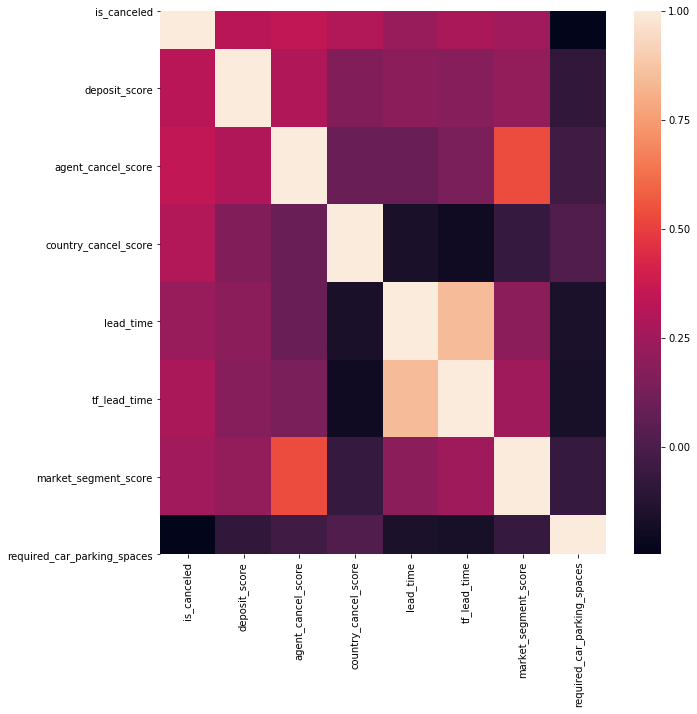

In [20]:
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(features_df.corr())

features_df.corr()

# The Models

The models ran best with the original lead time data, and without counting the interaction between agent and market_segment.

The Decision Tree Boosting model had accuracy at 76%, still relatively weak for a class-imbalanced dataset like this one.

KNN Nearest Neighboor model produced accuracty between 68.2% and 70.4%

Random Forest produced the lowest accuracy at 66%.

In [21]:
#Model Evaluation Libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#### Test/Train Split 

In [22]:
train_df = features_df[features_df['w_date'] <= '2017-05-31']
test_df = features_df[features_df['w_date'] > '2017-05-31']

In [23]:
# Y is the target variable
y_train = train_df['is_canceled']
y_test = test_df['is_canceled']

# X is the feature set
x_train = train_df[['deposit_score', 'agent_cancel_score', 'country_cancel_score', 'market_segment_score', 'required_car_parking_spaces','lead_time']]
x_test = test_df[['deposit_score', 'agent_cancel_score', 'country_cancel_score', 'market_segment_score', 'required_car_parking_spaces','lead_time']]

## Random Forest

In [24]:
#Random Forest Libraries
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [25]:
rfc = ensemble.RandomForestClassifier(n_jobs=-1)

#Hyper-parameter tuning
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [26]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 200}

In [27]:
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=4, criterion='entropy')

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

Accuracy Score: 0.6883542919628212


In [28]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79      3409
           1       0.77      0.25      0.38      2078

    accuracy                           0.69      5487
   macro avg       0.72      0.60      0.59      5487
weighted avg       0.71      0.69      0.64      5487



## Gradient Boosting

In [29]:
#Libraries
import scipy
from sklearn import ensemble
from IPython.display import Image
import pydotplus
import graphviz

#### Max Depth 2, default parameters

Weak learner 0 R^2: 0.7129579004920722
Weak learner 20 R^2: 0.7129579004920722


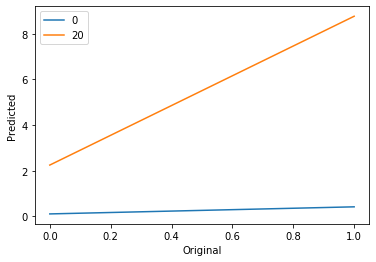

Accuracy Score: 0.7129579004920722


In [30]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['is_canceled'].unique()

for m in range(0, 21):
    
    # Initialize and fit the tree. Set the max depth to 2.
    gradient_boost = ensemble.GradientBoostingClassifier(max_depth=2)
    gradient_boost.fit(x_train,y_train)
    
    # Get and store predicted values.
    y_pred = gradient_boost.predict(x_test)
    preds['pred{}'.format(m)] = y_pred
    
    # Residuals.
    residuals = y_test - y_pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, gradient_boost.score(x_test, y_test)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(test_df['is_canceled'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

In [31]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.79      3409
           1       0.70      0.42      0.52      2078

    accuracy                           0.71      5487
   macro avg       0.71      0.66      0.66      5487
weighted avg       0.71      0.71      0.69      5487



#### Max Depth 8, default parameters

Weak learner 0 R^2: 0.7519591762347366
Weak learner 20 R^2: 0.7521414251868052
Weak learner 40 R^2: 0.7519591762347366
Weak learner 60 R^2: 0.7519591762347366
Weak learner 80 R^2: 0.7523236741388737
Weak learner 100 R^2: 0.7519591762347366


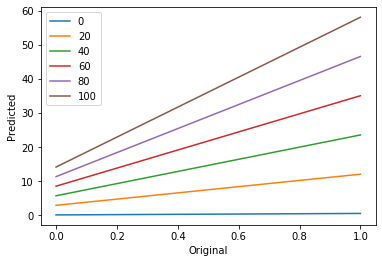

Accuracy Score: 0.7519591762347366


In [42]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['is_canceled'].unique()

for m in range(0, 61):
    
    # Initialize and fit the tree. Set the max depth to 2.
    gradient_boost = ensemble.GradientBoostingClassifier(max_depth=8)
    gradient_boost.fit(x_train,y_train)
    
    # Get and store predicted values.
    y_pred = gradient_boost.predict(x_test)
    preds['pred{}'.format(m)] = y_pred
    
    # Residuals.
    residuals = y_test - y_pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, gradient_boost.score(x_test, y_test)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(test_df['is_canceled'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

In [43]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3409
           1       0.71      0.58      0.64      2078

    accuracy                           0.75      5487
   macro avg       0.74      0.72      0.72      5487
weighted avg       0.75      0.75      0.75      5487



#### Max Depth 8, max_features=sqrt, default parameters

Weak learner 0 R^2: 0.7577911427009295
Weak learner 20 R^2: 0.7566976489885183
Weak learner 40 R^2: 0.7570621468926554
Weak learner 60 R^2: 0.7556041552761071
Weak learner 80 R^2: 0.7559686531802442
Weak learner 100 R^2: 0.7523236741388737
Weak learner 120 R^2: 0.7594313832695462
Weak learner 140 R^2: 0.7528704209950793
Weak learner 160 R^2: 0.7521414251868052
Weak learner 180 R^2: 0.7577911427009295
Weak learner 200 R^2: 0.7565154000364498


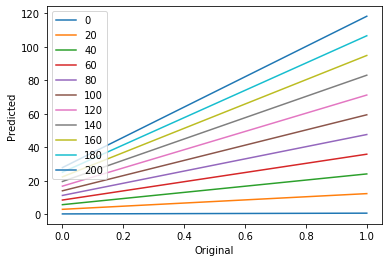

Accuracy Score: 0.7565154000364498


In [46]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['is_canceled'].unique()

for m in range(0, 201):
    
    # Initialize and fit the tree. Set the max depth to 2.
    gradient_boost = ensemble.GradientBoostingClassifier(max_depth=8,max_features='sqrt')
    gradient_boost.fit(x_train,y_train)
    
    # Get and store predicted values.
    y_pred = gradient_boost.predict(x_test)
    preds['pred{}'.format(m)] = y_pred
    
    # Residuals.
    residuals = y_test - y_pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, gradient_boost.score(x_test, y_test)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(test_df['is_canceled'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

In [47]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3409
           1       0.72      0.59      0.65      2078

    accuracy                           0.76      5487
   macro avg       0.75      0.72      0.73      5487
weighted avg       0.75      0.76      0.75      5487



## KNN

In [32]:
#Libraries
from sklearn.neighbors import KNeighborsClassifier

In [33]:
neighbors = KNeighborsClassifier(n_neighbors=1)

neighbors.fit(x_train,y_train)

knn_results = cross_val_score(neighbors, x_train, y_train, cv=10)

y_pred = neighbors.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

knn_results.mean()

Accuracy Score: 0.6983779843265902


0.7208714384183266

In [34]:
neighbors = KNeighborsClassifier(n_neighbors=2)

neighbors.fit(x_train,y_train)

knn_results = cross_val_score(neighbors, x_train, y_train, cv=10)

y_pred = neighbors.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

knn_results.mean()

Accuracy Score: 0.6819755786404228


0.7514754423185245

In [35]:
neighbors = KNeighborsClassifier(n_neighbors=3)

neighbors.fit(x_train,y_train)

knn_results = cross_val_score(neighbors, x_train, y_train, cv=10)

y_pred = neighbors.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

knn_results.mean()

Accuracy Score: 0.7036632039365773


0.750213782696177

In [36]:
neighbors = KNeighborsClassifier(n_neighbors=4)

neighbors.fit(x_train,y_train)

knn_results = cross_val_score(neighbors, x_train, y_train, cv=10)

y_pred = neighbors.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

knn_results.mean()

Accuracy Score: 0.6841625660652452


0.7597201966074338

In [37]:
neighbors = KNeighborsClassifier(n_neighbors=5)

neighbors.fit(x_train,y_train)

knn_results = cross_val_score(neighbors, x_train, y_train, cv=10)

y_pred = neighbors.predict(x_test)

print('Accuracy Score:', accuracy_score(y_test, y_pred))

knn_results.mean()

Accuracy Score: 0.7009294696555495


0.7563166559245962

In [38]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78      3409
           1       0.65      0.47      0.54      2078

    accuracy                           0.70      5487
   macro avg       0.68      0.66      0.66      5487
weighted avg       0.69      0.70      0.69      5487



### Notebook Summary

In this notebook, I built several models to model if a given booking would be canceled. Although the models worked very well on the training data, they were not very accurate on new data.

Had one of these models achieved a high degree of accuracy, it would be potentially valuable in a very microscopic sense. If a modeling pipeline could be built around it to effeciently sort bookings based on their cancellation risks I see the possiblity of some valuable business applications.